# Data Processing and Models


Content:
+ [1. Loading Libraries](#1.-Loading-Libraries)
+ [2. Loading data](#2.-Loading-data)
+ [3. Text preprocessing](#3.-Text-preprocessing)
+ [4. Frequency analysis](#4.-Frequency-analysis)
+ [5. Vectorization](#5.-Vectorization)
+ [6. Baseline. LogisticRegression](#6.-Baseline.-LogisticRegression)

## 1. Loading Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

import emoji
from langdetect import detect

import re
import nltk

nltk.download('stopwords')
nltk.download('punkt')

import emoji
from num2words import num2words
from nltk.corpus import stopwords
import pymorphy2

from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm

from autocorrect import Speller

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


## 2. Loading data 

In [18]:
df = pd.read_csv("joined_df_multi_clean.csv", index_col=0)
df.head()

,text,age,label,assessment,Война и мир,Игра в войну,Реальность виртуального,Антимилитаризм,Свой-чужой,Патриотизм,...,СВО и ее последствия,Актуальные проблемы,Критика власти/режима,Поддержка власти/режима,Принадлежность к идеологии: левый,Принадлежность к идеологии: правый,Принадлежность к идеологии: либерал/центрист,Ценности: гуманизм/антигуманизм,Мобилизационный и/или мотивационный потенциал,Международная и/или мировая политика
0,"Одна из тех не многих игр, по прохождению кото...",23-30,1.0,0.0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,"Узнал , про эту игру из ленты новостей. Я как ...",17-22,0.0,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Прошел я Tales of Bayun от российской студии F...,23-30,0.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Купил эту игру из подборки, в порыве поддержат...",30+,0.0,0.0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,"По совету проверенного товарища, третьего дня ...",23-30,1.0,0.0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10723 entries, 0 to 11782
Data columns (total 35 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   text                                             10723 non-null  object 
 1   age                                              2094 non-null   object 
 2   label                                            10723 non-null  float64
 3   assessment                                       10722 non-null  float64
 4   Война и мир                                      10723 non-null  int64  
 5   Игра в войну                                     10723 non-null  int64  
 6   Реальность виртуального                          10723 non-null  int64  
 7   Антимилитаризм                                   10723 non-null  int64  
 8   Свой-чужой                                       10723 non-null  int64  
 9   Патриотизм                       

In [19]:
for col in df.columns[1:]:
    print(df[col].value_counts())

age
Любой                                       895
30+                                         562
17-22                                       333
23-30                                       246
До 17                                        52
0                                             4
)                                             1
а у полицейских вместо дубинок косяки)))      1
Name: count, dtype: int64
label
0.0    10391
1.0      332
Name: count, dtype: int64
assessment
0.0    10064
1.0      658
Name: count, dtype: int64
Война и мир
0    9830
1     893
Name: count, dtype: int64
Игра в войну 
0    9892
1     831
Name: count, dtype: int64
Реальность виртуального 
0    10277
1      446
Name: count, dtype: int64
Антимилитаризм
0    10488
1      235
Name: count, dtype: int64
Свой-чужой 
0    10645
1       78
Name: count, dtype: int64
Патриотизм 
0    10376
1      347
Name: count, dtype: int64
Положительная оценка СССР
0    9723
1    1000
Name: count, dtype: int64
Отрицательная оценк

In [20]:
tmp = df[(df.age == '0') | (df.age == ')') | (df.age == 'а у полицейских вместо дубинок косяки)))')]
df = df.drop(tmp.index)

In [21]:
df.age.isna().sum()

8629

In [22]:
df.age.value_counts()

age
Любой    895
30+      562
17-22    333
23-30    246
До 17     52
Name: count, dtype: int64

In [34]:
df = df.drop(df[df.assessment.isna()].index)

In [35]:
for col in df.columns[1:]:
    print(df[col].unique())

['23-30' '17-22' '30+' 'До 17' 'Любой' nan]
[1. 0.]
[0. 1.]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [ ]:
# def replace(df, cols, values):
#     for col in cols:
#         df[col] = 

# def remove(df, col, values):
#     ...

In [4]:
print(df.label.value_counts())
print()
print(df.assessment.value_counts())
print()
print("Matches:", len(df[df.label == df.assessment]))

label
1.0    7373
0.0    4406
Name: count, dtype: int64

assessment
1.0    6585
0.0    5194
Name: count, dtype: int64

Matches: 7917


Как мы видим, не всегда, но часто, метка комментария совпадает с его оценкой.

In [6]:
# languages = {}
# troubles = []
# for i, line in enumerate(df.text):
#     try:
#         lg = detect(line)
#     except Exception:
#         print(i, line)
#         troubles.append(i)
#         continue

#     try:
#         languages[lg] += [i]
#     except KeyError:
#         languages[lg] = [i]

#     # df.iloc[i, 0] = blob.translate(to='ru')
    

1004 1
1299 ]]
4444 1


Ниже можно увидеть, что коментарии написаны на нескольких языках, проверим их и переведем на русский.

In [7]:
# for lang, nums in languages.items():
#     print(lang, len(nums), sep='\t')

ru	10871
uk	345
bg	382
mk	167
da	1
en	9
nl	1


Хм, что же с этим делать... заменим на стилистически нейтральные синонимы

In [ ]:
# df.iloc[languages['et'], 0] = "хохлы плохие люди, сало уронили!"

In [23]:
# for line in df.iloc[languages['en'], 0]:
#     print(line)

In English below.Не рекомендую приобретать этот мод к Men of War: Assault Squad 2 и тому несколько причин:1) Одиночной сюжетной компании нет, есть схватка с ии на произвольной карте;2) Не нашел прямого управления бронетехникой как в Men of War: Assault Squad 2;3) Нет обучения;4) Графика не стала лучше;5) Упростили всё что можно до примитивного, а  ожидал рытье окопов и изменяемую землю.Есть и плюсы: Понравилось нововедение с покупкой отрядов в колоду.I do not recommend purchasing this mod for Men of War: Assault Squad 2 and there are several reasons for this:1) There is no single story campaign, there is a fight with AI on an arbitrary map;2) I did not find direct control of armored vehicles as in Men of War:1 Assault Squad 2;3) No training;4) Graphics did not get better;5) We simplified everything that is possible to the primitive, but I expected digging trenches and changeable land.There are pluses: I liked the innovation with the purchase of units in the deck.
This company spat in t

In [28]:
# from deep_translator import LingueeTranslator

# translated_word = LingueeTranslator(source='english', target='russian').translate("Ukrainian ")
# translated_word

'украинский'

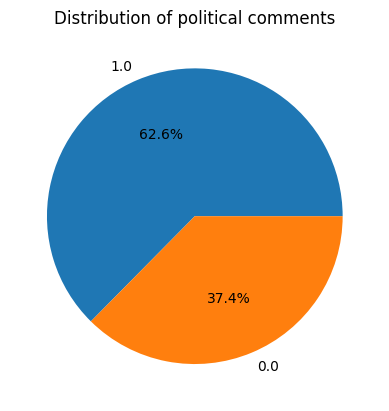

In [5]:
df['label'].value_counts().plot(kind='pie', title='Distribution of political comments', autopct='%1.1f%%')
plt.axis('off')
plt.show()

Есть дисбаланс классов, поэтому используем метрики *F1*, *precision* и *recall* для оценки качества предсказания моделей в будущем. 

## 3. Text preprocessing

Посмотрим на эмодзи и эмотиконы в данных.

In [ ]:
# em_lst = []

# for i, line in enumerate(tmp_df.text):
#     lst_emoji = emoji.emoji_list(line)

#     if lst_emoji:
#         for tmp in lst_emoji:
#             em_lst += [tmp['emoji']]
    


In [ ]:
# unique_emo = set(em_lst)

In [ ]:
# print(unique_emo)

{'🎮', '🙂', '🥶', '🆗', '➡', '🕹️', '🩷', '🌏', '🍾', '🤭', '🕉️', '3️⃣', '🇬🇪', '😵\u200d💫', '🌼', '🌻', '🛐', '🚫', '🪯', '🦾', '📃', '😻', '🐎', '👨', '🇯🇴', '🕋', '👫', '🤛🏼', '👎🏻', '🥇', '🙁', '🇵🇸', '🙌', '🇮🇹', '🥺', '👥', '🌺', '🌸', '🇲🇳', '🐒', '🚩', '✅', '🥀', '⚛️', '💊', '😅', '🚶\u200d♂', '🇷🇺', '🍷', '😌', '👎', '😲', '🍞', '😄', '🤓', '‼️', '♥️', '👆', '👊', '🔯', '🤯', '✊', '🎊', '🐑', '🏙', '🎖', '😜', '👬', '☹', '🤙', '☠️', '🙇\u200d♀️', '😘', '😳', '🙏🏻', '🙏', '🥉', '🤞', '🌚', '🎶', '🏆', '🧗\u200d♂️', '💽', '🌈', '🕊', '🧔', '😇', '🤬', '🇹🇯', '✔️', '☠', '🇺🇸', '🤡', '⬛', '🥳', '🥴', '🤘', '🤥', '☯️', '🐔', '🎺', '👍', '👩', '🚂', '🎬', '🍇', '🟥', '🇩🇿', '😏', '👐', '👏🏻', '🔲', '😹', '💸', '🦂', '🫡', '👍🏻', '😈', '🕯', '🖐🏻', '😝', '◀', '🤷', '🙈', '🇱🇹', '🌊', '🫶', '🔝', '🏅', '🇮🇶', '✡️', '🎆', '🦴', '🙇\u200d♂️', '😤', '🧂', '👉', '👈', '📺', '🧐', '🐐', '💺', '🔂', '👌🏻', '💪🏼', '🪐', '😋', '⚠️', '🏛️', '🟢', '❤️\u200d🔥', '🤧', '🐄', '🇺🇦', '⬜', '⚖️', '🌐', '🇰🇿', '🌿', '🖕', '🤕', '🫤', '🇧🇾', '💨', '🥔', '✌', '🙄', '💩', '🥈', '🪦', '☮️', '👳🏿\u200d♂️', '📜', '👱\u200d♀', '💪🏽', '❤️', '😣', '♥', '☝️', '🧑

In [ ]:
# de_emoji_str = ""
# for emo in unique_emo:
#     de_emoji_str += emoji.demojize(emo, language='ru') + "\n"


In [ ]:
# print(de_emoji_str)

:видеоигры:
:слегка_улыбается:
:мерзнет:
:значок_«ОК»:
:стрелка_вправо:
:джоистик:
:розовое_сердце:
:Азия_и_Австралия_на_земном_шаре:
:шампанское:
:прикрывает_рот_рукой:
:ом:
:клавиши_3:
:флаг_Грузия:
:ошеломление:
:цветок:
:подсолнух:
:религия:
:запрещено:
:кханда:
:механическая_рука:
:страница_с_загибом:
:влюбленный_кот:
:лошадь:
:мужчина:
:флаг_Иордания:
:Кааба:
:мужчина_и_женщина:
:кулак_влево_светлый_тон_кожи:
:большой_палец_вниз_очень_светлый_тон_кожи:
:золотая_медаль:
:немного_грустит:
:флаг_Палестинские_территории:
:ура:
:флаг_Италия:
:умоляет:
:два_силуэта:
:гибискус:
:цветок_вишни:
:флаг_Монголия:
:обезьяна:
:треугольный_флаг:
:белая_галочка:
:увядший_цветок:
:символ_атома:
:пилюля:
:нервно_смеется:
:мужчина_идет:
:флаг_Россия:
:бокал_вина:
:испытывает_облегчение:
:большой_палец_вниз:
:в_шоке:
:хлеб:
:смеется_с_закрытыми_глазами:
:очкарик:
:два_восклицательных_знака:
:червы:
:указывающий_вверх_палец:
:кулак:
:шестиконечная_звезда:
:взрыв_мозга:
:поднятый_кулак:
:конфетти:
:ов

In [ ]:
# import emot
# emot_obj  = emot.emot()

# emoticons_lst = []

# for i, line in enumerate(tmp_df.text):
#     emotic = emot_obj.emoticons(line)

#     for tmp in lst_emoji:
#         emoticons_lst += [tmp['value']]
    


In [ ]:
# emoticons_lst

[]

В целом, можно заменить эмодзи на русские слова.

In [12]:
df = pd.read_csv(r'C:\Users\zlata\Documents\parser_ign\joined_df_multi_clean.csv', index_col=0)

In [13]:
df

,text,age,label,assessment,Война и мир,Игра в войну,Реальность виртуального,Антимилитаризм,Свой-чужой,Патриотизм,...,СВО и ее последствия,Актуальные проблемы,Критика власти/режима,Поддержка власти/режима,Принадлежность к идеологии: левый,Принадлежность к идеологии: правый,Принадлежность к идеологии: либерал/центрист,Ценности: гуманизм/антигуманизм,Мобилизационный и/или мотивационный потенциал,Международная и/или мировая политика
0,"Одна из тех не многих игр, по прохождению кото...",23-30,1.0,0.0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
1,"Узнал , про эту игру из ленты новостей. Я как ...",17-22,0.0,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Прошел я Tales of Bayun от российской студии F...,23-30,0.0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Купил эту игру из подборки, в порыве поддержат...",30+,0.0,0.0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,"По совету проверенного товарища, третьего дня ...",23-30,1.0,0.0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10804,"2:30:08, Я всегда говорил, правопреемник СССР ...",NaN,0.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10805,Скорее всего тут не прямой умысел обосрать сою...,NaN,0.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10807,"25:51 Вот этим СССР, для меня, и отличается от...",NaN,0.0,1.0,1,1,1,0,1,0,...,0,0,0,1,1,0,0,0,1,0
10808,"Насчет игр, где США готовили и осуществляли на...",NaN,1.0,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [14]:
df["text"] = df["text"].str.lower()

In [16]:
TOKEN_RE = re.compile(r'[а-яё]+')
russian_stopwords = stopwords.words("russian")
def pymorphy2_311_hotfix():
    from inspect import getfullargspec
    from pymorphy2.units.base import BaseAnalyzerUnit

    def _get_param_names_311(klass):
        if klass.__init__ is object.__init__:
            return []
        args = getfullargspec(klass.__init__).args
        return sorted(args[1:])

    setattr(BaseAnalyzerUnit, '_get_param_names', _get_param_names_311)
pymorphy2_311_hotfix()
lemmatizer = pymorphy2.MorphAnalyzer()
# corrector_fred = T5ModelForSpellingCorruption.from_pretrained(AvailableCorrectors.sage_fredt5_large.value)
spell = Speller('ru')

def tokenize_text(txt, min_lenght_token=2):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_lenght_token]

def remove_special_chars(text):
    """Удаляет специальные символы из строки на русском языке"""
    # Регулярное выражение для поиска специальных символов
    pattern = r'[^\w\s\u0400-\u04FF\d]'
    return re.sub(pattern, '', text)

# Функция для преобразования эмоджи в слова
def emojis_words(text):
    # Модуль emoji: преобразование эмоджи в их словесные описания
    clean_text = emoji.demojize(text, delimiters=(" ", " "), language='ru')
    # Редактирование текста путём замены ":" и" _", а так же - путём добавления пробела между отдельными словами
    clean_text = clean_text.replace(":", "").replace("_", " ")   
    return clean_text

def convert_nums2words(text):
    words = []
    for word in text.split():
        if word.isdigit():
            words += [num2words(word, lang='ru')]
        else:
            words.append(word)
    return " ".join(words)

# Функция для очистки текста
def cleaning_text(input_text):    
    
    # HTML-теги: первый шаг - удалить из входного текста все HTML-теги
    clean_text = re.sub('<[^<]+?>', '', input_text)
    
    # URL и ссылки: далее - удаляем из текста все URL и ссылки
    clean_text = re.sub(r'http\S+', '', clean_text)

    # Эмоджи и эмотиконы: используем собственную функцию для преобразования эмоджи в текст
    # Важно понимать эмоциональную окраску обрабатываемого текста
    clean_text = emojis_words(clean_text)
    
    # Убираем все пробелы
    # Так как все данные теперь представлены словами - удалим пробелы
    clean_text = re.sub('\s+', ' ', clean_text)

    # # Убираем специальные символы: избавляемся от всего, что не является "словами"
    # clean_text = re.sub('[^a-zA-Z0-9\s]', '', clean_text)

    # Записываем числа прописью: 100 превращается в "сто" (для компьютера)

    # clean_text = corrector_fred.correct(clean_text)

    clean_text = spell(clean_text)

    clean_text = convert_nums2words(clean_text)

    # Стоп-слова: удаление стоп-слов - это стандартная практика очистки текстов
    stop_words = set(stopwords.words('russian'))
    tokens = tokenize_text(clean_text)
    lemmas = [lemmatizer.parse(token)[0].normal_form for token in tokens]
    lemmas = [lemma for lemma in lemmas if lemma not in stop_words]

    clean_text = ' '.join(lemmas)

    # # Знаки препинания: далее - удаляем из текста все знаки препинания
    # clean_text = re.sub(r'[^\w\s]', '', clean_text)

    clean_text = remove_special_chars(clean_text)

    # И наконец - возвращаем очищенный текст
    return clean_text



In [18]:
tqdm.pandas()
df_token = df.copy()
df_token = df_token.progress_apply

1076


In [19]:
df_token = df_token.drop(1076)

In [21]:
for col in df_token.columns:
    print(df_token[col].value_counts())

text
слава украине                                                                                                                                                                                                                                           13
слава україні                                                                                                                                                                                                                                           11
я гей                                                                                                                                                                                                                                                    9
слава россии                                                                                                                                                                                                                                      

In [43]:
df_noage = df.drop(columns=['age']).dropna()

In [46]:
df.shape

(10716, 35)

In [45]:
df_noage.shape

(10716, 34)

In [ ]:
df_token.to_csv("multi_df_politics.csv")

In [7]:
# tqdm.pandas()

# df_token = df.copy()
# df_token['text'] = df_token['text'].progress_apply(cleaning_text)
# df_token.head()

100%|██████████| 14412/14412 [01:35<00:00, 151.45it/s]


,comment,toxic
0,верблюд дебил бл,1.0
1,хохол это отдушина затюканый россиянин мол вон...,1.0
2,собака собачий смерть,1.0
3,страница обновить дебил это оскорбление доказа...,1.0
4,убедить страничный пдф скрипаль отравить росси...,1.0


Check if empty texts appeared after tokenization and delete them if they exist 

In [172]:
df = pd.read_csv('cleaned_bin_df_politics.csv', index_col=0)

In [173]:
df_dup = df.copy()
empty = df[(df.text == '') | (df.text == ' ')]
print('Number of empty texts: ', len(empty))
df = df.drop(empty.index)

Number of empty texts:  0


Check data for duplicates 

In [174]:
print('Number of duplicates:', df.duplicated().sum())

Number of duplicates: 345


In [175]:
df = df.drop_duplicates()

Check comments for duplicates 

In [176]:
print('Number of duplicate comments: ', df['text'].duplicated().sum())

Number of duplicate comments:  75


In [122]:
df.isna().sum()

text          4
label         0
assessment    0
dtype: int64

In [177]:
df = df.dropna()

In [178]:
from collections import Counter

In [179]:
c = Counter(list(df.loc[df.text.duplicated(), 'text']))
c

Counter({'война': 3,
         'слава украина': 3,
         'негр': 3,
         'победа': 2,
         'власть': 2,
         'украина': 1,
         'донбасс': 1,
         'рекомендовать игра нацелить убийство украинец типичный росс пропаганда поэтому вернуть свой деньга игра': 1,
         'вставать донбасс': 1,
         'игра стоить внимание хотя разработчик взяться красочно раскрыть сразу интересный тема широкий использование поезд время гражданский война россия боевой путь чехословацкий легион кстати первый симулятор поезд война создать российский разработчик игра причём сеттинг стать гражданский война почемуть сша игра получиться простенький песочница торговля курьерский миссия забавный боёвка противостояние южанин северянин служить лишь фон ставить игрок понастоящий сложный задача предлагать гораздо проработать механика управление поезд экстремальный условие особый упор судьба член экипаж обеспечение припас выживание время жестокий война представитель самый разный политический сила р

In [125]:
list(df[df.text.str.split().apply(len) == 1].text)

['донбасс',
 'хр',
 'украина',
 'свинорез',
 'симулятор',
 'украина',
 'донбасс',
 'ликвидировать',
 'гойд',
 'нарк',
 'хрю',
 'лнр',
 'война',
 'война',
 'перемога',
 'россиюматушка',
 'гей',
 'демократия',
 'симулятор',
 'нацик',
 'фашист',
 'сво',
 'батут',
 'продолжаться',
 'бахбахмут',
 'харьков',
 'свинья',
 'сало',
 'негр',
 'хохлов',
 'бахмат',
 'бандёр',
 'гей',
 'укв',
 'войнаплохо',
 'русофоб',
 'гойд',
 'украинец',
 'буквально',
 'хрю',
 'мясосать',
 'скиньяхрюшкахохолсвинарниксвинтусбекончик',
 'днр',
 'поросёнок',
 'рука',
 'прощатьпригожинвласовец',
 'вагнер',
 'пригодный',
 'шойгу',
 'путин',
 'россия',
 'кгб',
 'победа',
 'гитлер',
 'негр',
 'перемога',
 'негр',
 'антисоветчина',
 'чвксила',
 'вагнер',
 'пригожин',
 'чвк',
 'война',
 'лукашенко',
 'ганьба',
 'пуллера',
 'лукашенко',
 'пуллера',
 'ураураурапобед',
 'победа',
 'победа',
 'путин',
 'ждать',
 'это',
 'россия',
 'снимать',
 'рашка',
 'весь',
 'кремлебот',
 'отправка',
 'власть',
 'власть',
 'пидоргын',
 'ок

In [180]:
df[df.text == 'израильтеррорист'].text = 'израиль террорист'
df[df.text == 'россиюматушка'].text = 'россия матушка'

In [181]:
df = df.drop_duplicates()

In [182]:
df[df.text == 'продолжаться']

,text,label,assessment
965,продолжаться,1.0,0.0


In [183]:
df = df.drop(df[df.text.str.split().apply(len) == 1].text.index)

In [184]:
df.duplicated().sum()

np.int64(0)

## 4. Frequency analysis 

In [185]:
# Counting the occurrence of each word in the corpus 
corpus = df[df.label == 1].text.values

text = ' '.join(corpus)
counter = Counter(text.split())
sorted_counter = counter.most_common()
sorted_counter[:10]

[('это', 3642),
 ('игра', 2585),
 ('всё', 1970),
 ('весь', 1645),
 ('россия', 1627),
 ('который', 1409),
 ('война', 1372),
 ('человек', 1294),
 ('свой', 1151),
 ('большой', 968)]

In [186]:
# Counting the occurrence of each word in the corpus 
corpus = df[df.label == 0].text.values

text = ' '.join(corpus)
counter = Counter(text.split())
sorted_counter = counter.most_common()
sorted_counter[:10]

[('игра', 2235),
 ('это', 2095),
 ('всё', 1144),
 ('который', 987),
 ('весь', 801),
 ('россия', 727),
 ('война', 680),
 ('очень', 650),
 ('свой', 623),
 ('смеяться', 613)]

In [187]:
# Counting the occurrence of each word in the corpus 
corpus = df.text.values

text = ' '.join(corpus)
counter = Counter(text.split())
sorted_counter = counter.most_common()
sorted_counter[:10]

[('это', 5737),
 ('игра', 4820),
 ('всё', 3114),
 ('весь', 2446),
 ('который', 2396),
 ('россия', 2354),
 ('война', 2052),
 ('свой', 1774),
 ('человек', 1729),
 ('мочь', 1484)]

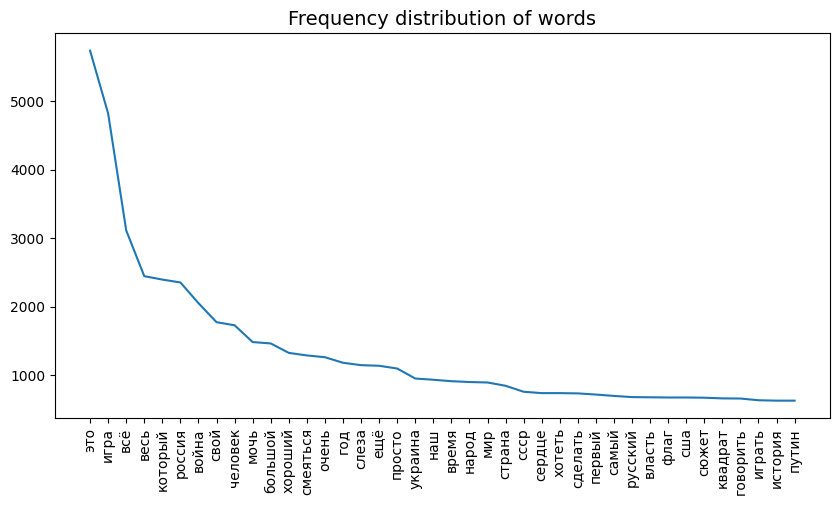

In [188]:
# Drawing a graph of the frequency of words 
words = [pair[0] for pair in sorted_counter]
words_count = [pair[1] for pair in sorted_counter]

plt.figure(figsize=(10, 5))
plt.plot(words[:40], words_count[:40])
plt.xticks(rotation=90)
plt.title('Frequency distribution of words', fontsize=14)
plt.show()

In [189]:
def remove_some(s, lst = ['игра', 'это', 'всё', 'который', 'весь']):
    for i in lst:
        s = s.replace(i, '')
    return s

In [190]:
df.text = df.text.apply(remove_some)

we will create a "word cloud" 

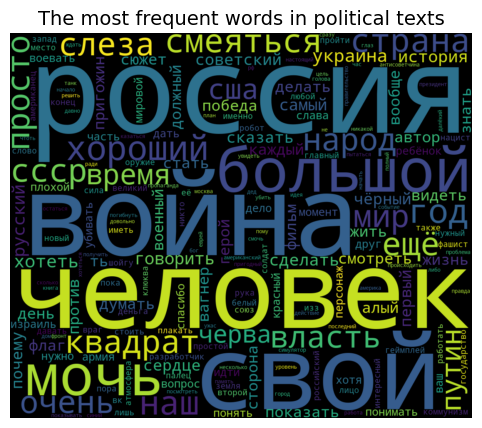

In [141]:
only_politic = df[df.label == 1]
text_politic = ' '.join(only_politic.text.values)

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text_politic)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('The most frequent words in political texts', fontsize=14)
plt.show()

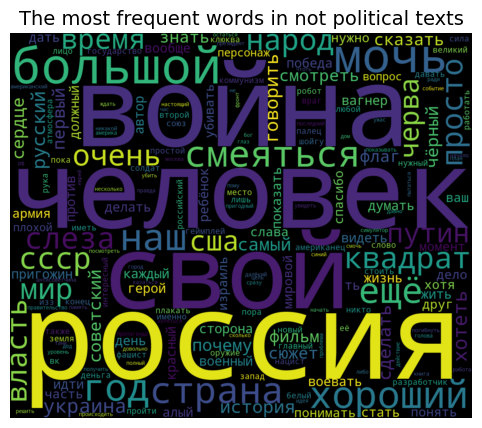

In [142]:
only_nopolitic = df[df.label == 0]
text_nopolitic = ' '.join(only_politic.text.values)

wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text_nopolitic)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('The most frequent words in not political texts', fontsize=14)
plt.show()

In [202]:
a, b = sorted(dict(df['label'].value_counts()).items())
print(a, b)

(0.0, np.int64(4210)) (1.0, np.int64(7114))


In [208]:
def balance_dataset(df, target_col):
    a, b = sorted(dict(df[target_col].value_counts()).items())
    print(a, b)
    if (a[1] > b[1]):
        tmp = df.loc[df[target_col] == 1].sample(n = abs(a[1] - b[1]))
    else:
        tmp = df.loc[df[target_col] == 0].sample(n = abs(a[1] - b[1]))
    df = pd.concat([df, tmp], ignore_index=True)
    return df

In [209]:
tt = df.copy()
tt = balance_dataset(tt, 'label')
tt

(0.0, np.int64(4210)) (1.0, np.int64(7114))


,text,label,assessment
0,многий прохождение прочитать титр узнать имя...,1.0,1.0
1,узнать лента новость человек следить отечеств...,1.0,0.0
2,пройти российский студия разработчик описывать...,1.0,0.0
3,купить подборка порыв поддержать отечественны...,1.0,0.0
4,совет проверить товарищ третий день купить под...,1.0,1.0
...,...,...,...
14223,бедуин глушить стереть ваш вагнер украина,0.0,0.0
14224,наш город чел сидеть тюряга предложить воить к...,0.0,0.0
14225,аххаа дон делать бжжжжжж ум,0.0,1.0
14226,комик ть ветеран афганаэтый оскорбление настоя...,0.0,0.0


In [210]:
tt.label.value_counts()

label
1.0    7114
0.0    7114
Name: count, dtype: int64

In [223]:
tt.to_csv("final_bin_df_politicts_v1.csv")

## 5. Vectorization 

In [228]:
df = pd.read_csv('final_bin_df_politicts_v1.csv', index_col=0)

In [ ]:
df.label = df.label.astype(int)

In [233]:
df_train, df_test = train_test_split(df, 
                                     random_state=42, 
                                     test_size=0.2, 
                                     stratify=df.label
                                    )

train_corpus = df_train.text.values
test_corpus = df_test.text.values

y_train = df_train.label
y_test = df_test.label

In [234]:
vectorizer = TfidfVectorizer(ngram_range=(2,4), analyzer='char_wb', max_df=0.8, min_df=10)
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

print('Total features: ', len(vectorizer.get_feature_names_out()))

Total features:  19105


## 6. Baseline. LogisticRegression

In [214]:
Logregres = LogisticRegression(max_iter=10000, C=3, solver='liblinear')
Logregres.fit(X_train, y_train)
y_pred = Logregres.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.77      0.77      1423
         1.0       0.77      0.76      0.76      1423

    accuracy                           0.77      2846
   macro avg       0.77      0.77      0.77      2846
weighted avg       0.77      0.77      0.77      2846



In [218]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [219]:
cm = confusion_matrix(y_test, y_pred, labels=Logregres.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Logregres.classes_)

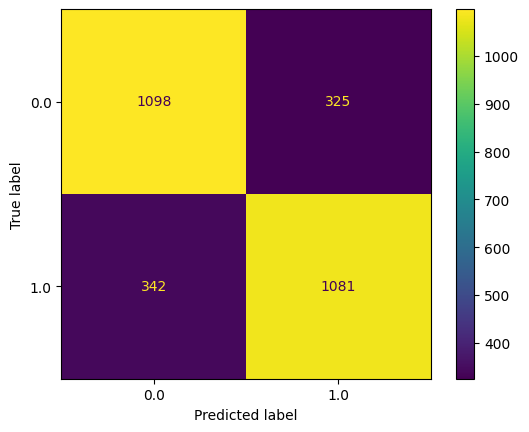

In [220]:
disp.plot()
plt.show()

In [221]:
from sklearn import metrics

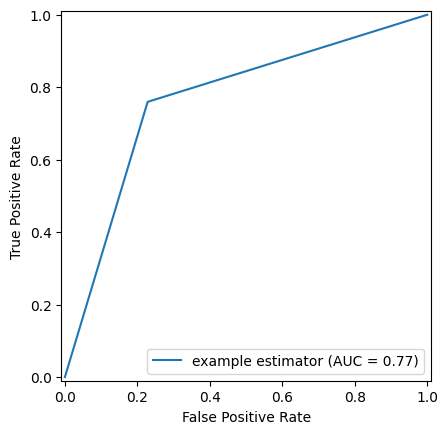

In [222]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()